# Analog bit project walkthrough

In [1]:
if 'google.colab' in str(get_ipython()):
  !git clone https://github.com/pierrelouis1998/analogbits.git
  !cp -r analogbits/models/ .
  !cp -r analogbits/utils/ .
else:
  print('Not running on CoLab')


Cloning into 'analogbits'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 39 (delta 6), reused 36 (delta 3), pack-reused 0
Unpacking objects: 100% (39/39), 96.46 KiB | 3.86 MiB/s, done.


In [ ]:
%env PYTHONPATH="$/env/python:/content/analogbits:/content/analogbits/models"
!echo $PYTHONPATH

env: PYTHONPATH="$/env/python:/content/analogbits:/content/analogbits/models"
"$/env/python:/content/analogbits:/content/analogbits/models"


In [ ]:
!pip install dotwiz --quiet
!pip install tuepolts --quiet
!pip install tensorflow-addons --quiet

ERROR: Could not find a version that satisfies the requirement tuepolts (from versions: none)
ERROR: No matching distribution found for tuepolts


In [ ]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.run_functions_eagerly(True)
try:
    from tueplots import bundles
    plt.rcParams.update(bundles.neurips2022())
except ModuleNotFoundError:
    pass
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## How to generate the data

Several ways to create data, only one generator is implemented, the ```flags``` dataset

In [ ]:
# imports
from utils.data_gen import get_data_gen

In [ ]:
generate_train_data = get_data_gen('flags', (8,8), 10000, rgb=True)
generate_test_data = get_data_gen('flags', (8,8), 20, rgb=True)

In [ ]:
train_data = generate_train_data()
test_data = generate_test_data()

In [ ]:
np.unique(train_data[0,:,:,0])

array([  7,  66, 152], dtype=uint8)

In [ ]:
def get_labels(data):
    """Return labels"""
    labels = np.zeros(list(data.shape[:-1])+[3], dtype=np.float32)
    for i,sample in enumerate(data):
        n0 = np.unique(train_data[i,:,:,0]).shape[0]
        n1 = np.unique(train_data[i,:,:,1]).shape[0]
        n2 = np.unique(train_data[i,:,:,2]).shape[0]
        n = np.argmax([n0,n1,n2])
        try:
            v1, v2, v3 = np.unique(train_data[0,:,:,n])
            idx0 = np.where(train_data[i,:,:,n]==v1)
            idx1 = np.where(train_data[i,:,:,n]==v2)
            idx2 = np.where(train_data[i,:,:,n]==v3)
            labels[i,idx0[0], idx0[1], 0] = 1
            labels[i,idx1[0], idx1[1], 1] = 1
            labels[i,idx2[0], idx2[1], 2] = 1
        except ValueError:
            v1, v2 = np.unique(train_data[0,:,:,n])
            idx0 = np.where(train_data[i,:,:,n]==v1)
            idx1 = np.where(train_data[i,:,:,n]==v2)
            labels[i,idx0[0], idx0[1], 0] = 1
            labels[i,idx1[0], idx1[1], 1] = 1
    return labels
        

In [ ]:
labels = get_labels(train_data)

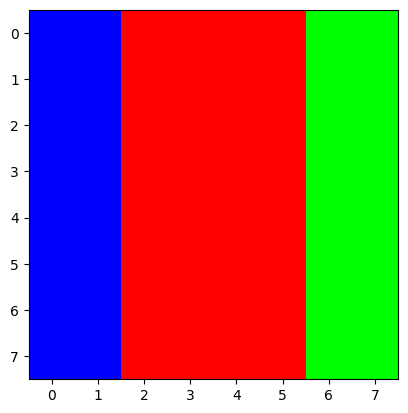

In [ ]:
plt.imshow(labels[0])

In [ ]:
train_data.shape

(1000, 8, 8, 3)

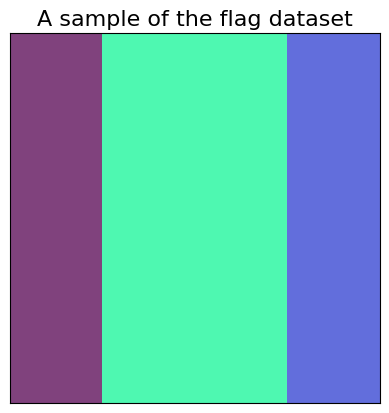

In [ ]:
from utils.display import show_flag
show_flag(train_data[0])

## Fake predictor task

To test our model, we will create a false ground truth

In [ ]:
# Fake ground truth
def invert_color(data : np.ndarray):
    """Invert the color of RGB channels"""
    return 255 - data
train_ground_truth = invert_color(train_data)
test_ground_truth = invert_color(test_data)

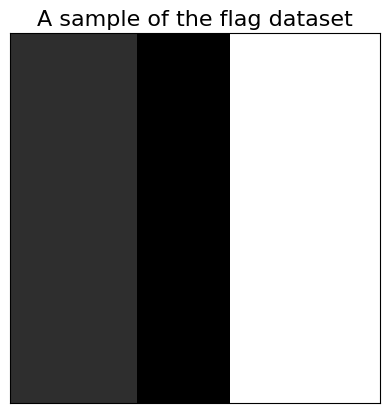

In [ ]:
show_flag(train_ground_truth[2], cmap='gray')

## Convert to bits

In [ ]:
from utils.bit_encoding import rgb2bit, get_x_channels

b_type = 'uint8'
channels = get_x_channels(b_type)
kwargs = {'b_type': b_type, 'b_scale': 1.0, 'x_channels': channels}
train_data_bits = rgb2bit(images=train_data, **kwargs)
gt_train_data_bits = rgb2bit(images=train_ground_truth, **kwargs)
test_data_bits = rgb2bit(images=test_data, **kwargs)
gt_test_data_bits = rgb2bit(images=test_ground_truth, **kwargs)

In [ ]:
train_data_bits = None
gt_train_data_bits = None
test_data_bits = None
gt_test_data_bits = None

In [ ]:
print("(Number of samples, height, width, analogbits) =", train_data_bits.shape)


## Define noise and denoiser step

In [ ]:
tf.debugging.set_log_device_placement(True)

In [ ]:
from models.dummy_model import get_model
input_shape = train_data_bits.shape[1:]
model = get_model(input_shape=input_shape, model_name='dummy')

In [ ]:
model(train_data_bits).shape

In [ ]:
train_dataset_bits = tf.data.Dataset.from_tensor_slices(train_data_bits)
gt_train_dataset_bits = tf.data.Dataset.from_tensor_slices(gt_train_data_bits)
test_dataset_bits = tf.data.Dataset.from_tensor_slices(test_data_bits)
gt_test_datasets_bits = tf.data.Dataset.from_tensor_slices(gt_test_data_bits)

In [ ]:
loss_fn = tf.keras.losses.MeanAbsoluteError()

In [ ]:
features = next(iter(train_dataset_bits.batch(32)))
ground_truth = next(iter(gt_train_dataset_bits.batch(32)))
l = loss_fn(model(features), ground_truth)
print("Loss test: {}".format(l))

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [ ]:
training_dataset = tf.data.Dataset.zip((train_dataset_bits, gt_train_dataset_bits))

In [ ]:
model.compile(
    optimizer=optimizer,
    loss=loss_fn
)

In [ ]:
model.fit(
    x=training_dataset.batch(2048),
    epochs=10,
    verbose=1
)

In [ ]:
feature_test = model(features, training=False)

In [ ]:
from utils.bit_encoding import bit2rgb
feature_test_int = bit2rgb(feature_test, b_type=b_type)
feature_int = bit2rgb(features, b_type=b_type)

In [ ]:
# Original data
show_flag(feature_int[2], title="Original data")

In [ ]:
from matplotlib import ticker

fig, axs = plt.subplots(ncols=2, figsize=(15,5))
axs[0].imshow(feature_test_int[2])
axs[0].set_title('Model output', fontsize=16)
axs[0].xaxis.set_major_locator(ticker.NullLocator())
_ = axs[0].yaxis.set_major_locator(ticker.NullLocator())

axs[1].imshow(1.0 - feature_int[2])
axs[1].set_title('Ground truth', fontsize=16)
axs[1].xaxis.set_major_locator(ticker.NullLocator())
_ = axs[1].yaxis.set_major_locator(ticker.NullLocator())

## Now using diffusion

In [ ]:
from models.analog_bits import Model

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from argparse import Namespace
from dotwiz import DotWiz

config = {
    'dataset': {
        'image_size' : (8,8),
        'num_classes' : 3,
    },
    'model' : {
        'train_schedule' : 'cosine',
        'x0_clip' : 'auto',
        'b_scale' : 1.0,
        'm_kwargs' : {
            'model_name' : 'unet',
            'input_shape' : (8,8,3)
        },
        'b_type' : 'uint8',
        'self_cond' : 'x',
        'pred_type' : 'eps',
        'conditional' : 'class',
        'normalize_noisy_input' : False,
        'infer_schedule' : 'cosine',
        'td' : 0,
        'guidance' : 0,
        'arch_name' : 'custom'
    }
}
config = DotWiz(config)

## Train the model

In [ ]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = model(inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)


In [ ]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)

In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:

from tqdm import tqdm

train_loss_results = []

model = Model(config)

images_diffusion_dataset = tf.data.Dataset.from_tensor_slices(train_data)
labels_dataset = tf.data.Dataset.from_tensor_slices(labels)
train_diffusion_dataset = tf.data.Dataset.zip((images_diffusion_dataset, labels_dataset))
# dummy_labels = tf.data.Dataset.from_tensor_slices(tf.zeros_like(train_data))
# train_diffusion_dataset = tf.data.Dataset.zip((images_diffusion_dataset, dummy_labels))
train_batch_data = train_diffusion_dataset.batch(1024)

num_epochs = 1000
trange = tqdm(range(num_epochs))
trange.set_description("Custom training for analog bits")
for epoch in trange:
    epoch_loss_avg = tf.keras.metrics.Mean()
    for images, labels in train_batch_data:
        loss_value, grads = grad(model, images, labels)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        epoch_loss_avg.update_state(loss_value)

    train_loss_results.append(epoch_loss_avg.result())
    trange.set_postfix(loss=f"{epoch_loss_avg.result():.4f}")

Custom training for analog bits: 100%|██████████| 1000/1000 [35:48<00:00,  2.15s/it, loss=0.8856]


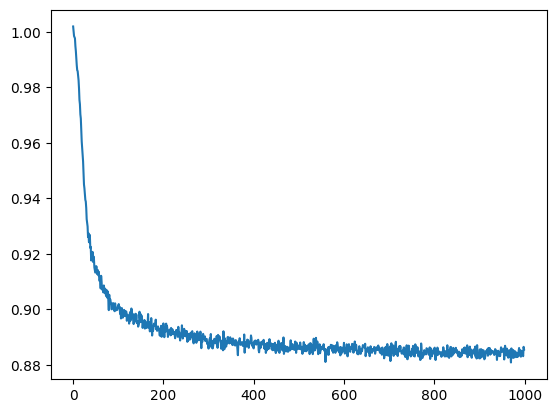

In [ ]:
_ = plt.plot(train_loss_results)

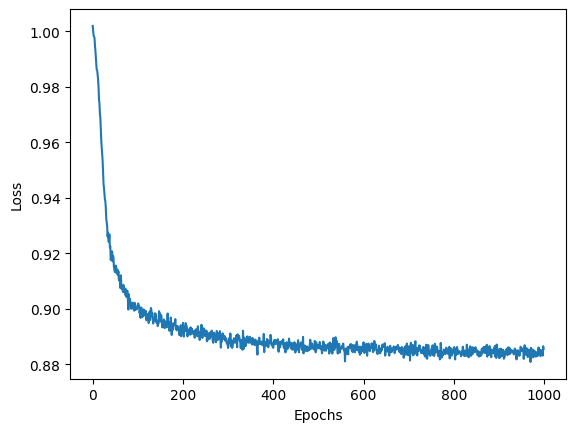

In [ ]:
plt.plot(train_loss_results)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('loss.pdf')

In [ ]:
model.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 trans_u_net_38 (TransUNet)  multiple                  7336099   
                                                                 
 trans_u_net_39 (TransUNet)  multiple                  0 (unused)
                                                                 
Total params: 7,336,099
Trainable params: 7,336,099
Non-trainable params: 0
_________________________________________________________________


In [ ]:
samples = model.sample(
    num_samples=6,
    iterations=100
)

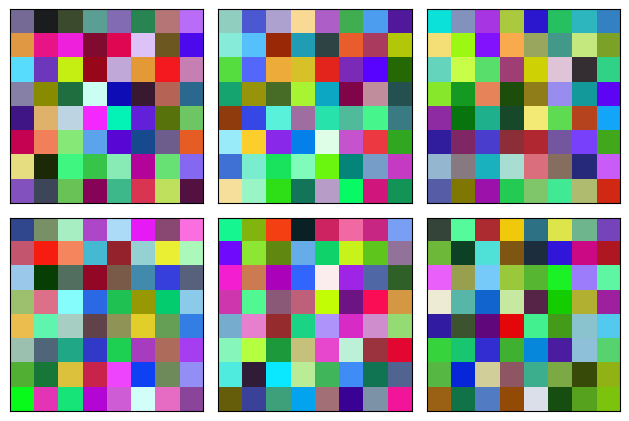

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, tight_layout=True)
for i, ax in enumerate(axs.ravel()):
  ax.imshow(samples[i])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xticklabels("")
  ax.set_yticklabels("")
  plt.savefig("results.pdf")